In [1]:
import numpy as np
import pydicom
import cv2
cv2.__version__
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.ndimage.morphology import binary_fill_holes

In [2]:
from dicomUtils import *
sample_dir = '../data/PACS/Larry_Smarr_2016/series_23_Cor_LAVA_PRE-Amira/'

In [3]:
sv = getVolume(sample_dir)

(512, 512)
(512, 512, 2)
(512, 512, 3)
(512, 512, 4)
(512, 512, 5)
(512, 512, 6)
(512, 512, 7)
(512, 512, 8)
(512, 512, 9)
(512, 512, 10)
(512, 512, 11)
(512, 512, 12)
(512, 512, 13)
(512, 512, 14)
(512, 512, 15)
(512, 512, 16)
(512, 512, 17)
(512, 512, 18)
(512, 512, 19)
(512, 512, 20)
(512, 512, 21)
(512, 512, 22)
(512, 512, 23)
(512, 512, 24)
(512, 512, 25)
(512, 512, 26)
(512, 512, 27)
(512, 512, 28)
(512, 512, 29)
(512, 512, 30)
(512, 512, 31)
(512, 512, 32)
(512, 512, 33)
(512, 512, 34)
(512, 512, 35)
(512, 512, 36)
(512, 512, 37)
(512, 512, 38)
(512, 512, 39)
(512, 512, 40)
(512, 512, 41)
(512, 512, 42)
(512, 512, 43)
(512, 512, 44)
(512, 512, 45)
(512, 512, 46)
(512, 512, 47)
(512, 512, 48)
(512, 512, 49)
(512, 512, 50)
(512, 512, 51)
(512, 512, 52)
(512, 512, 53)
(512, 512, 54)
(512, 512, 55)
(512, 512, 56)
(512, 512, 57)
(512, 512, 58)
(512, 512, 59)
(512, 512, 60)
(512, 512, 61)
(512, 512, 62)
(512, 512, 63)
(512, 512, 64)
(512, 512, 65)
(512, 512, 66)
(512, 512, 67)
(512, 5

In [4]:
simg = sv.raw_data[:,:,0]

In [5]:
simg.shape

(512, 512)

In [6]:
from util.AnDiffusion import *

In [7]:
diffusion = anisodiff(simg,20,50,0.1)

<IPython.core.display.Javascript object>


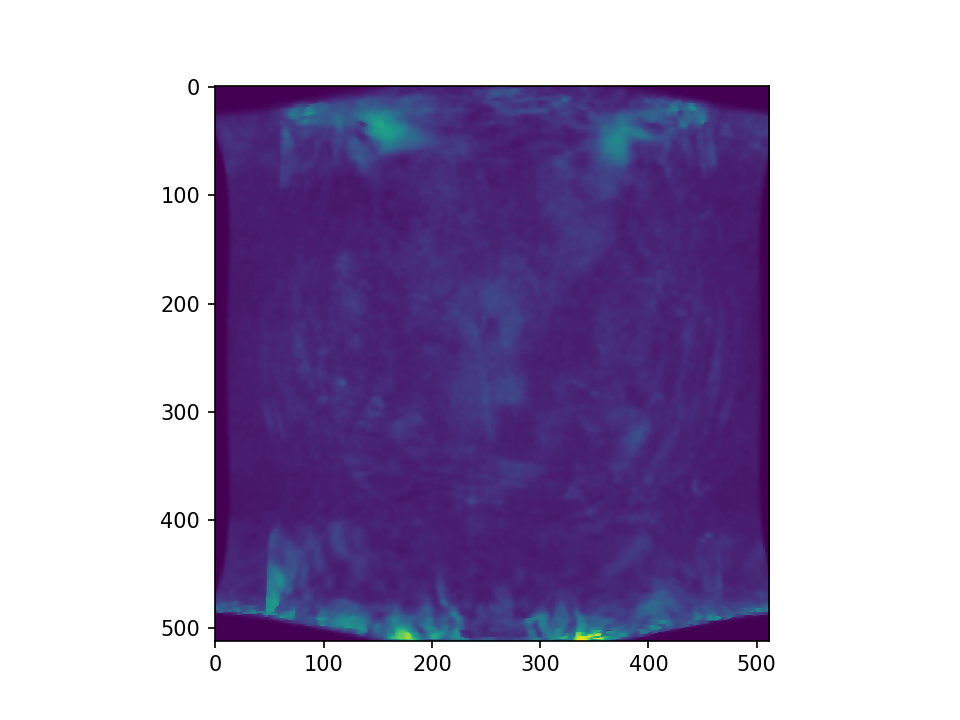

In [8]:
%matplotlib notebook
plt.imshow(diffusion)

In [10]:
mu,sigma = norm.fit(diffusion)

In [13]:
from util.hysteresisThresholding import apply_hysteresis_threshold

In [15]:
htr             = apply_hysteresis_threshold(diffusion,mu,sigma).astype(int)

<IPython.core.display.Javascript object>


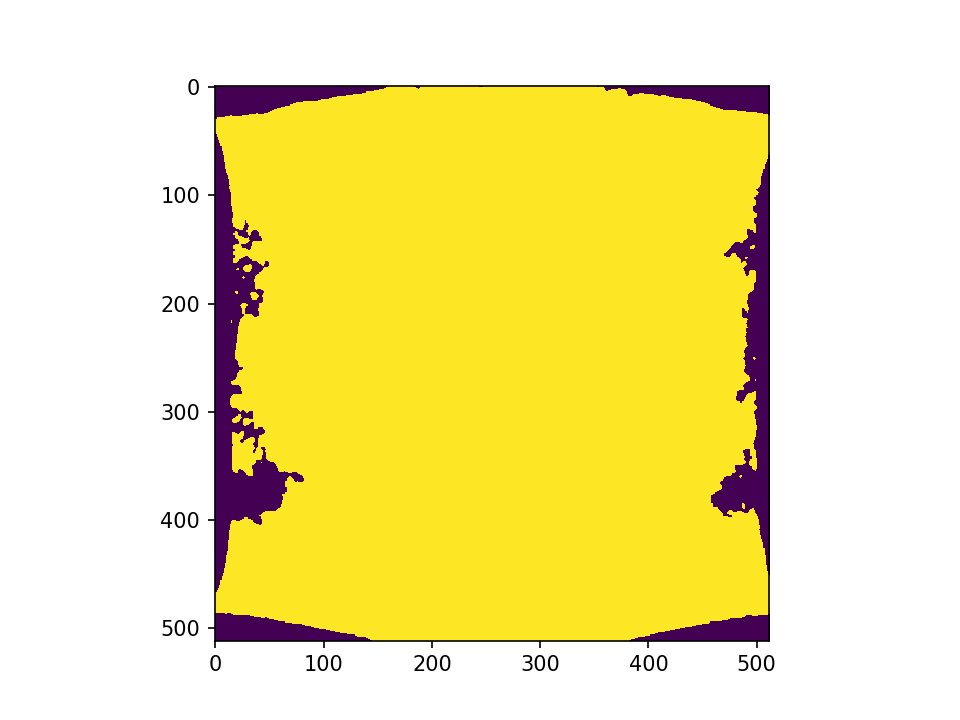

In [32]:
pmask           = binary_fill_holes(htr)
plt.imshow(pmask.astype(np.uint16))

<IPython.core.display.Javascript object>


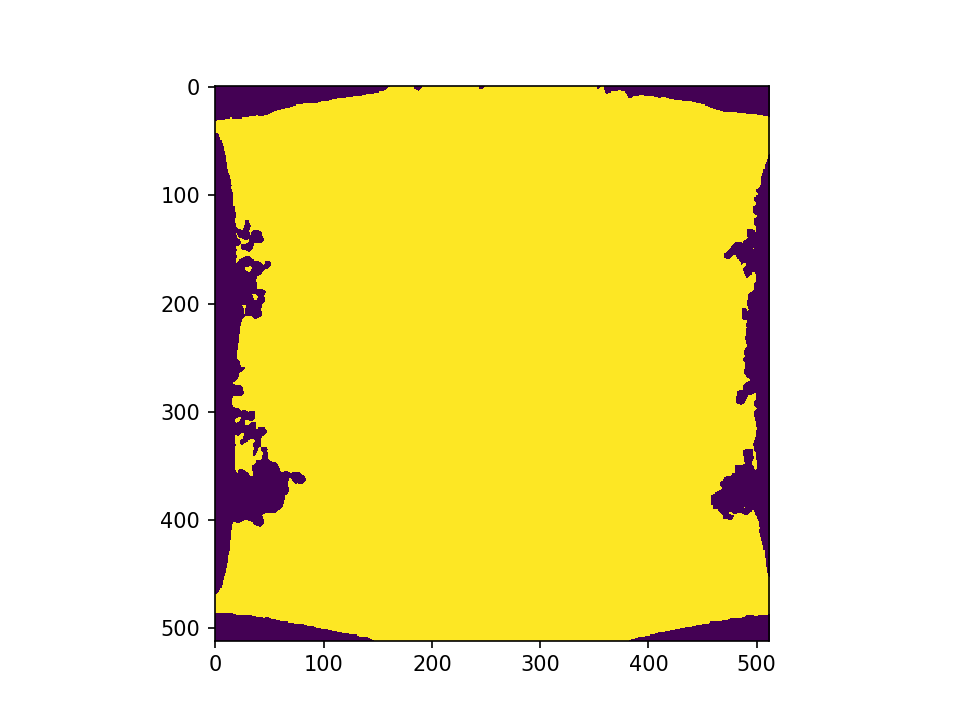

In [33]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))#np.ones((5,5),np.uint8)
erosion = cv2.erode(pmask.astype(np.uint16),kernel,iterations = 2)
plt.imshow(erosion)

In [1]:
from generateIndexFile import *


In [2]:
test_gen()

(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448, 3)
(512, 448, 4)
(512, 448, 5)
(512, 448, 6)
(512, 448, 7)
(512, 448, 8)
(512, 448, 9)
(512, 448, 10)
(512, 448, 11)
(512, 448, 12)
(512, 448, 13)
(512, 448, 14)
(512, 448, 15)
(512, 448, 16)
(512, 448, 17)
(512, 448, 18)
(512, 448, 19)
(512, 448, 20)
(512, 448, 21)
(512, 448, 22)
(512, 448, 23)
(512, 448, 24)
(512, 448, 25)
(512, 448, 26)
(512, 448, 27)
(512, 448, 28)
(512, 448, 29)
(512, 448, 30)
(512, 448, 31)
(512, 448, 32)
(512, 448, 33)
(512, 448, 34)
(512, 448, 35)
(512, 448, 36)
(512, 448, 37)
(512, 448, 38)
(512, 448, 39)
(512, 448, 40)
(512, 448, 41)
(512, 448, 42)
(512, 4

(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(352, 512)
(352, 512, 2)
(352, 512, 3)
(352, 512, 4)
(352, 512, 5)
(352, 512, 6)
(352, 512, 7)
(352, 512, 8)
(352, 512, 9)
(352, 512, 10)
(352, 512, 11)
(352, 512, 12)
(352, 512, 13)
(352, 512, 14)
(352, 512, 15)
(352, 512, 16)
(352, 512, 17)
(352, 512, 18)
(352, 512, 19)
(352, 512, 20)
(352, 512, 21)
(352, 512, 22)
(352, 5

(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 512)
(512, 512, 2)
(512, 512, 3)
(512, 512, 4)
(512, 512, 5)
(512, 512, 6)
(512, 512, 7)
(512, 512, 8)
(512, 512, 9)
(512, 512, 10)
(512, 512, 11)
(512, 512, 12)
(512, 512, 13)
(512, 512, 14)
(512, 512, 15)
(512, 512, 16)
(512, 512, 17)
(512, 512, 18)
(512, 512, 19)
(512, 512, 20)
(512, 512, 21)
(512, 512, 22)
(512, 512, 23)
(512, 512, 24)
(512, 512, 25)
(512, 512, 26)
(512, 512, 27)
(512, 512, 28)
(512, 512, 29)
(512, 512, 30)
(512, 512, 31)
(512, 512, 32)
(512, 512, 33)
(512, 512, 34)
(512, 512, 35)
(512, 448)
(512, 448, 2)
(512, 448)
(512, 448, 2)
(512, 448)
(

In [3]:
import scipy